In [ ]:
import pandas as pd
# from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
import shap
import lime
import lime.lime_tabular
from IPython.display import display, HTML

ImportError: cannot import name 'display' from 'IPython.core.display' (c:\Users\Singapore Athletic\Desktop\Alph\Sem2\BT5102\FinalProject\env\Lib\site-packages\IPython\core\display.py)

In [177]:
# drive.mount('/content/drive')

In [178]:
# Provide the path to the file in your Google Drive
# file_path = '/content/drive/My Drive/Colab Notebooks/DBA5102/Advertising_Kaggle/data/Advertising Budget and Sales.csv'
file_path = 'data/Advertising Budget and Sales.csv'

# Read the CSV file
df = pd.read_csv(file_path)

df = df.drop(columns=['Unnamed: 0'])

# Display the first few rows of the DataFrame
print(df.head())

   TV Ad Budget ($)  Radio Ad Budget ($)  Newspaper Ad Budget ($)  Sales ($)
0             230.1                 37.8                     69.2       22.1
1              44.5                 39.3                     45.1       10.4
2              17.2                 45.9                     69.3        9.3
3             151.5                 41.3                     58.5       18.5
4             180.8                 10.8                     58.4       12.9


<h1>EDA</h1>

In [179]:
# Rename columns for easier access
df.rename(columns={
    'TV Ad Budget ($)': 'TV_Budget',
    'Radio Ad Budget ($)': 'Radio_Budget',
    'Newspaper Ad Budget ($)': 'Newspaper_Budget',
    'Sales ($)': 'Sales'
}, inplace=True)

In [180]:
# Check data types
print(df.dtypes)

# Convert columns to numeric if necessary
df = df.astype({
    'TV_Budget': 'float',
    'Radio_Budget': 'float',
    'Newspaper_Budget': 'float',
    'Sales': 'float'
})

TV_Budget           float64
Radio_Budget        float64
Newspaper_Budget    float64
Sales               float64
dtype: object


In [181]:
df.describe()

,TV_Budget,Radio_Budget,Newspaper_Budget,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


In [182]:
# Check for missing values
print(df.isnull().sum())

TV_Budget           0
Radio_Budget        0
Newspaper_Budget    0
Sales               0
dtype: int64


In [183]:
# Check for duplicates
print(df.duplicated().sum())

# Remove duplicates if any
df.drop_duplicates(inplace=True)

0


In [184]:
# Create a new column for total advertising budget
df['Total_Budget'] = df['TV_Budget'] + df['Radio_Budget'] + df['Newspaper_Budget']

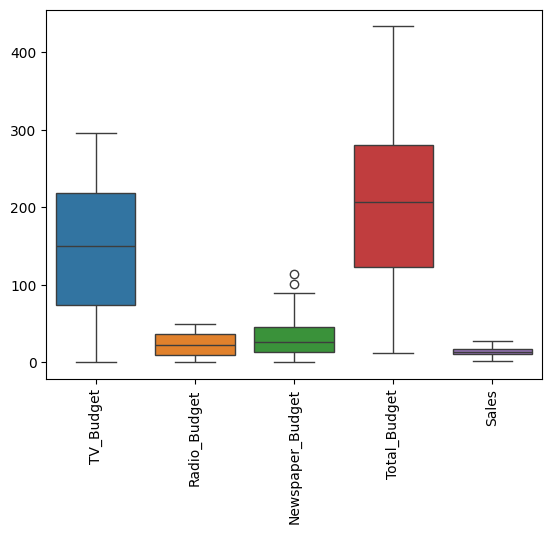

In [185]:
ax = sns.boxplot(data=df[['TV_Budget', 'Radio_Budget', 'Newspaper_Budget', 'Total_Budget', 'Sales']])
ax.tick_params(axis='x', rotation=90)
plt.show()

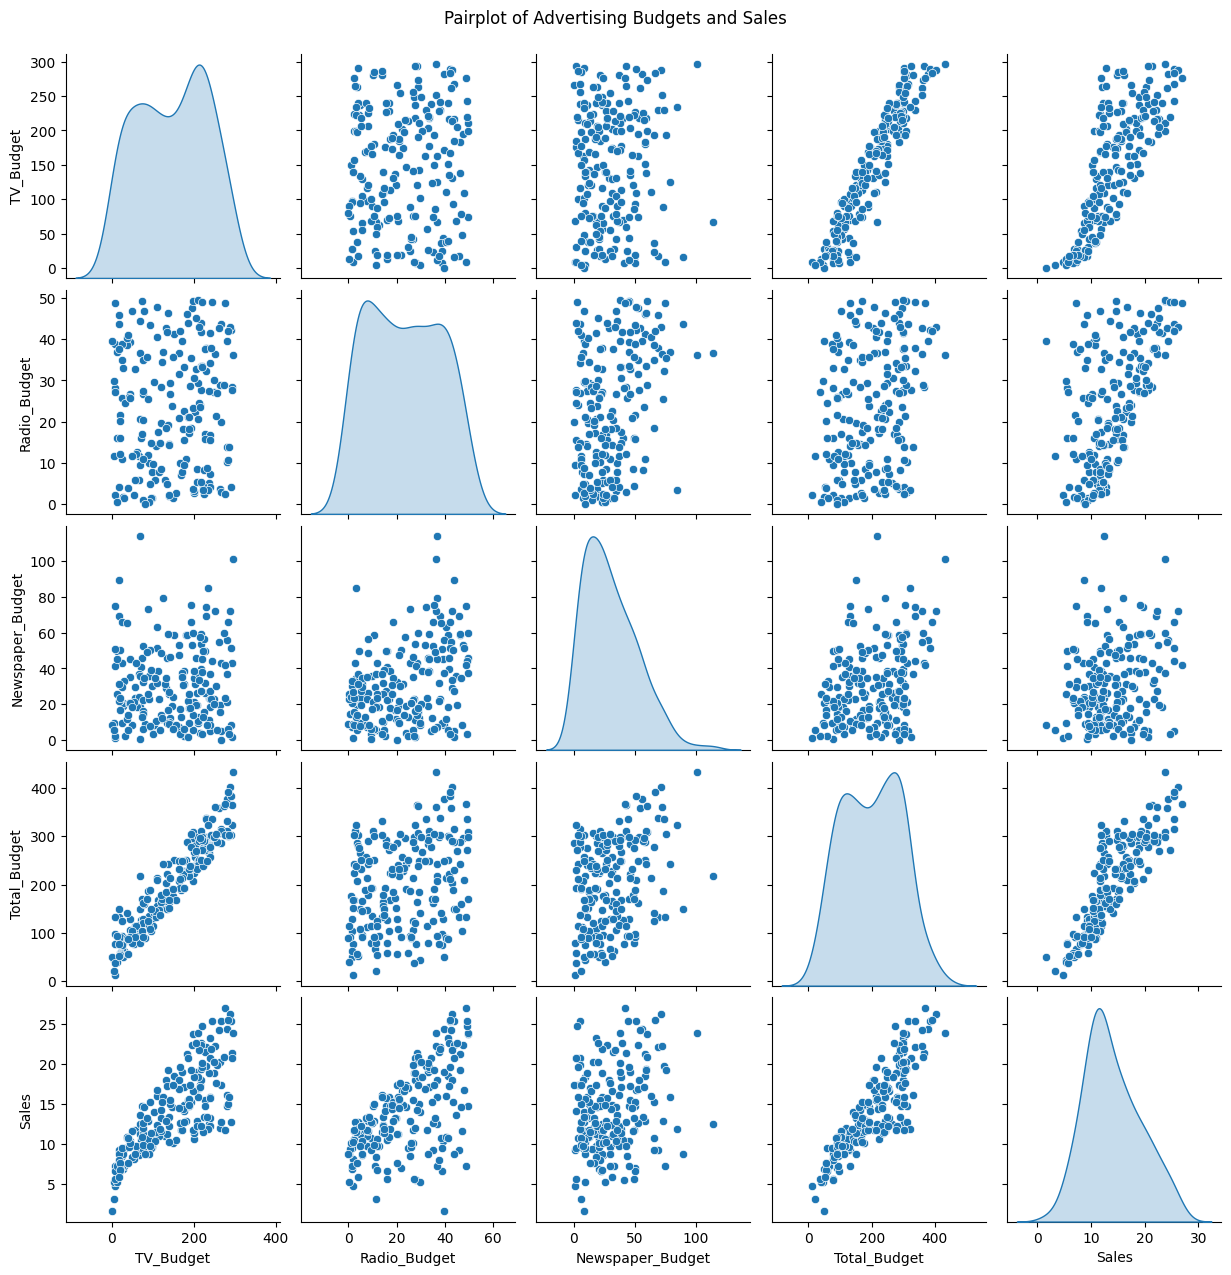

In [186]:
# Visualize distributions of advertising budgets and sales
sns.pairplot(df[['TV_Budget', 'Radio_Budget', 'Newspaper_Budget', 'Total_Budget', 'Sales']], diag_kind='kde')
plt.suptitle("Pairplot of Advertising Budgets and Sales", y=1.02)
plt.show()

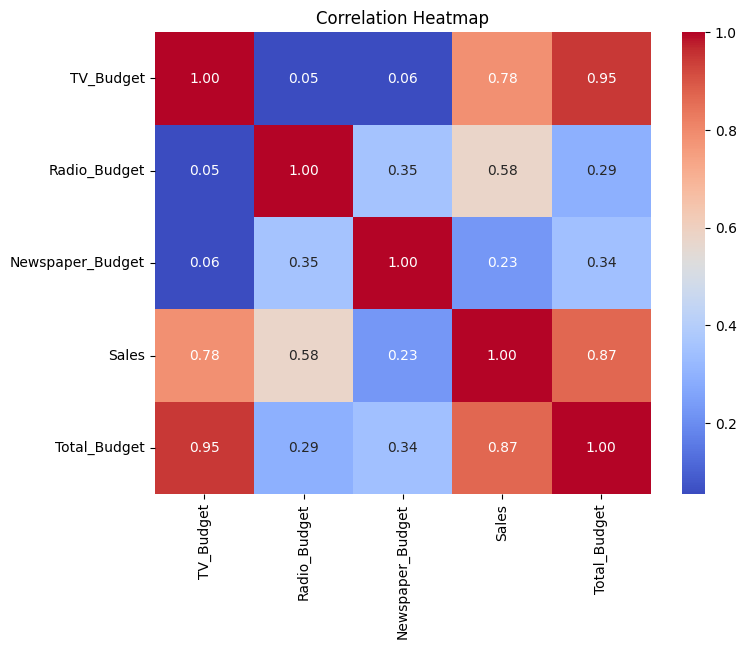

In [187]:
# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

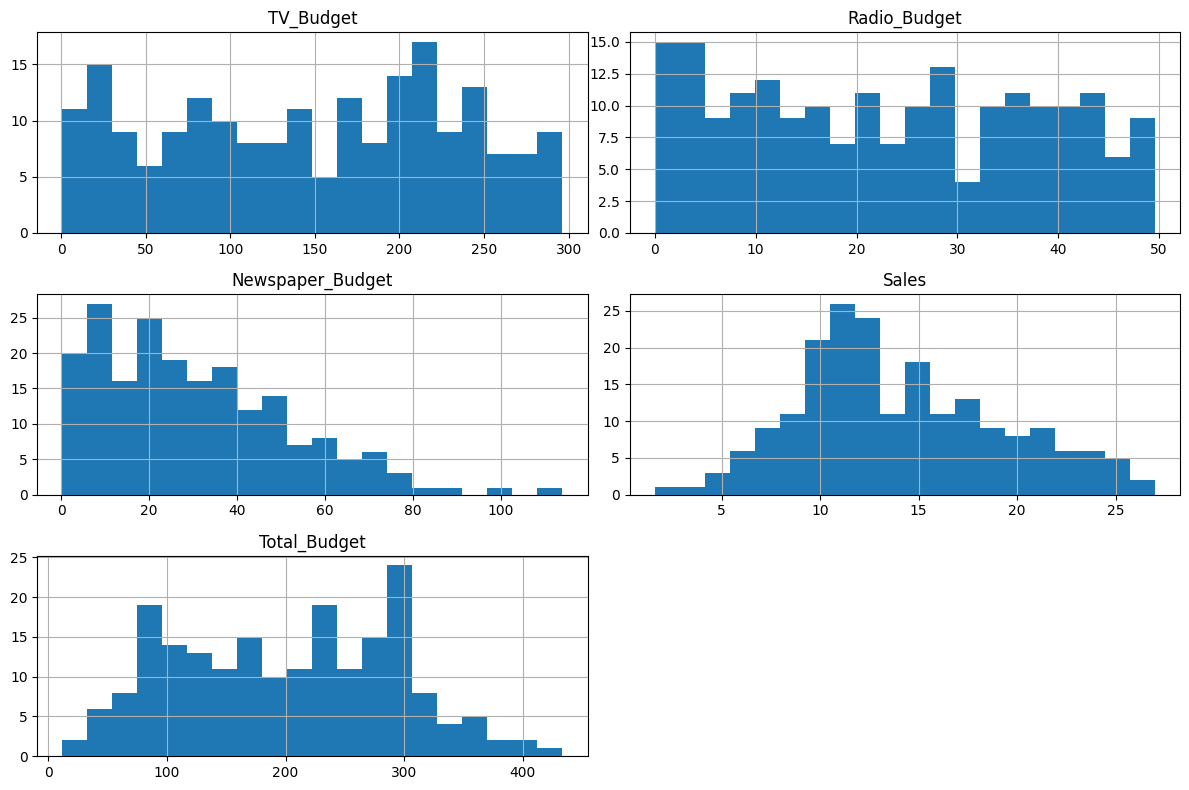

In [188]:
# Distribution of each variable
df.hist(bins=20, figsize=(12, 8))
plt.tight_layout()
plt.show()

<h1>Adding some features</h1>

In [189]:
# 1. Interaction terms between advertising budgets
df['TV_Radio_Interaction'] = df['TV_Budget'] * df['Radio_Budget']
df['TV_Newspaper_Interaction'] = df['TV_Budget'] * df['Newspaper_Budget']
df['Radio_Newspaper_Interaction'] = df['Radio_Budget'] * df['Newspaper_Budget']

In [190]:
df['TV_Radio_Ratio'] = df['TV_Budget'] / (df['Radio_Budget'] + 1e-5)
df['TV_Newspaper_Ratio'] = df['TV_Budget'] / (df['Newspaper_Budget'] + 1e-5)
df['Radio_Newspaper_Ratio'] = df['Radio_Budget'] / (df['Newspaper_Budget'] + 1e-5)

In [191]:
df['Log_TV'] = np.log1p(df['TV_Budget'])
df['Log_Radio'] = np.log1p(df['Radio_Budget'])
df['Log_Newspaper'] = np.log1p(df['Newspaper_Budget'])

In [192]:
df['TV_Squared'] = df['TV_Budget'] ** 2
df['Radio_Squared'] = df['Radio_Budget'] ** 2
df['Newspaper_Squared'] = df['Newspaper_Budget'] ** 2

df['TV_Sqrt'] = np.sqrt(df['TV_Budget'])
df['Radio_Sqrt'] = np.sqrt(df['Radio_Budget'])
df['Newspaper_Sqrt'] = np.sqrt(df['Newspaper_Budget'])

In [193]:
df['Mean_Ad_Budget'] = df[['TV_Budget', 'Radio_Budget', 'Newspaper_Budget']].mean(axis=1)
df['Std_Ad_Budget'] = df[['TV_Budget', 'Radio_Budget', 'Newspaper_Budget']].std(axis=1)
df['Max_Ad_Budget'] = df[['TV_Budget', 'Radio_Budget', 'Newspaper_Budget']].max(axis=1)
df['Min_Ad_Budget'] = df[['TV_Budget', 'Radio_Budget', 'Newspaper_Budget']].min(axis=1)

In [194]:
df['TV_Normalized'] = (df['TV_Budget'] - df['TV_Budget'].mean()) / df['TV_Budget'].std()
df['Radio_Normalized'] = (df['Radio_Budget'] - df['Radio_Budget'].mean()) / df['Radio_Budget'].std()
df['Newspaper_Normalized'] = (df['Newspaper_Budget'] - df['Newspaper_Budget'].mean()) / df['Newspaper_Budget'].std()

In [195]:
df['Cumulative_TV'] = df['TV_Budget'].cumsum()
df['Cumulative_Radio'] = df['Radio_Budget'].cumsum()
df['Cumulative_Newspaper'] = df['Newspaper_Budget'].cumsum()

In [196]:
df['Rolling_Mean_TV'] = df['TV_Budget'].rolling(window=3, min_periods=1).mean()
df['Rolling_Mean_Radio'] = df['Radio_Budget'].rolling(window=3, min_periods=1).mean()
df['Rolling_Mean_Newspaper'] = df['Newspaper_Budget'].rolling(window=3, min_periods=1).mean()

In [197]:
df['EMA_TV'] = df['TV_Budget'].ewm(span=5, adjust=False).mean()
df['EMA_Radio'] = df['Radio_Budget'].ewm(span=5, adjust=False).mean()
df['EMA_Newspaper'] = df['Newspaper_Budget'].ewm(span=5, adjust=False).mean()

In [198]:
df['High_TV_Budget'] = (df['TV_Budget'] > df['TV_Budget'].mean()).astype(int)
df['High_Radio_Budget'] = (df['Radio_Budget'] > df['Radio_Budget'].mean()).astype(int)
df['High_Newspaper_Budget'] = (df['Newspaper_Budget'] > df['Newspaper_Budget'].mean()).astype(int)

<h1>Modelling</h1>

In [199]:
# Features (X) and Target (y)
X = df.drop(columns=['Sales'])
y = df['Sales']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

# Train and evaluate models
results = {}
collect_models = {}
for name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)

    # Save the model for voting later
    collect_models[name] = model

    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}
    print(f"\n{name} Performance:")
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}\n\n")

# Identify the best-performing model
best_model_name = max(results, key=lambda x: results[x]['R2'])
best_model = models[best_model_name]
print(f"\nBest Performing Model: {best_model_name}")


Linear Regression Performance:
MAE: 0.30, RMSE: 0.36, R2: 1.00



Random Forest Performance:
MAE: 0.53, RMSE: 0.66, R2: 0.99



Gradient Boosting Performance:
MAE: 0.49, RMSE: 0.66, R2: 0.99



XGBoost Performance:
MAE: 0.54, RMSE: 0.67, R2: 0.99



Best Performing Model: Linear Regression


<h1>Explainability</h1>

In [200]:
# Permutation Feature Importance
perm_importance = permutation_importance(best_model, X_test, y_test, random_state=42)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)
print("\nPermutation Feature Importance:")
print(feature_importance)


Permutation Feature Importance:
                        Feature    Importance
0                     TV_Budget  1.676725e+01
17                   Radio_Sqrt  7.983384e+00
3                  Total_Budget  7.168575e+00
1                  Radio_Budget  2.362993e+00
16                      TV_Sqrt  1.742707e+00
11                    Log_Radio  1.330267e+00
10                       Log_TV  1.053527e+00
2              Newspaper_Budget  9.649723e-01
4          TV_Radio_Interaction  8.169321e-01
14                Radio_Squared  2.459852e-01
21                Max_Ad_Budget  1.799204e-01
13                   TV_Squared  8.768308e-02
19               Mean_Ad_Budget  8.694440e-02
20                Std_Ad_Budget  5.263171e-02
28         Cumulative_Newspaper  7.885577e-03
15            Newspaper_Squared  3.504147e-03
18               Newspaper_Sqrt  1.908916e-03
34                EMA_Newspaper  1.836599e-03
6   Radio_Newspaper_Interaction  1.336583e-03
31       Rolling_Mean_Newspaper  1.116236e-03
1

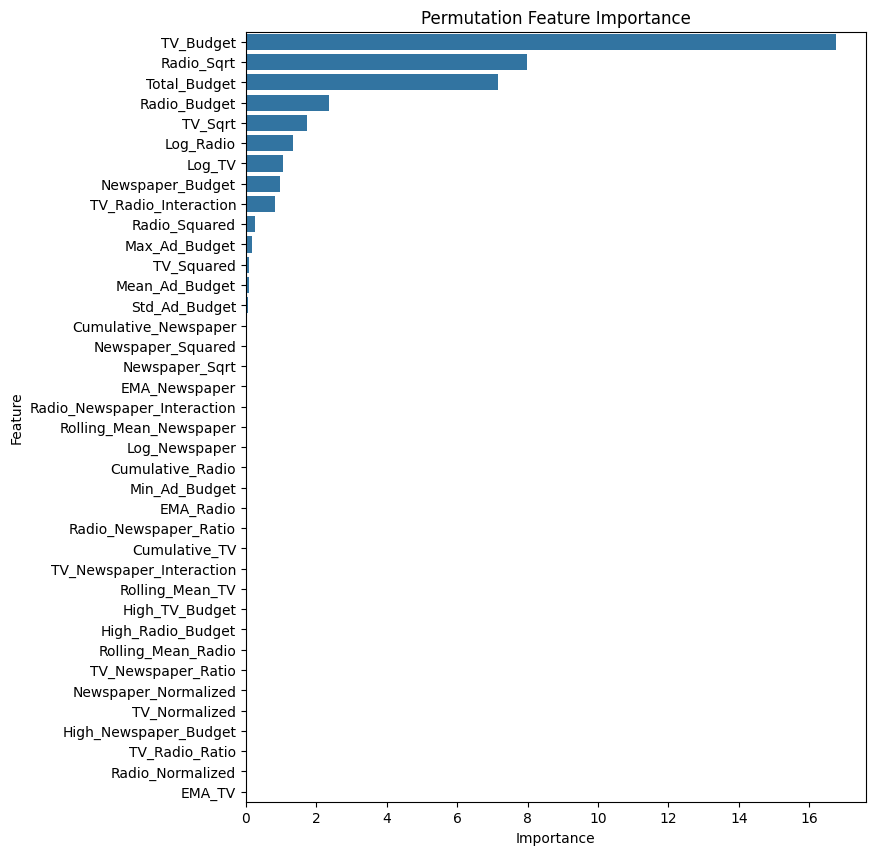

In [201]:
# Plot feature importance
plt.figure(figsize=(8, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title("Permutation Feature Importance")
plt.show()

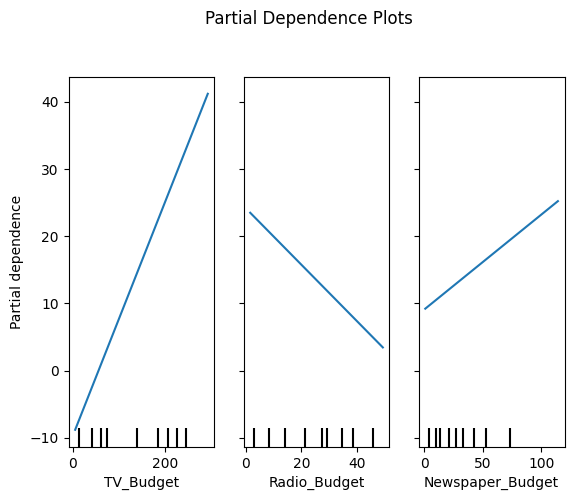

In [202]:
# Partial Dependence Plots (PDP)
PartialDependenceDisplay.from_estimator(best_model, X_test, features=[0, 1, 2], feature_names=X.columns)
plt.suptitle("Partial Dependence Plots", y=1.02)
plt.show()


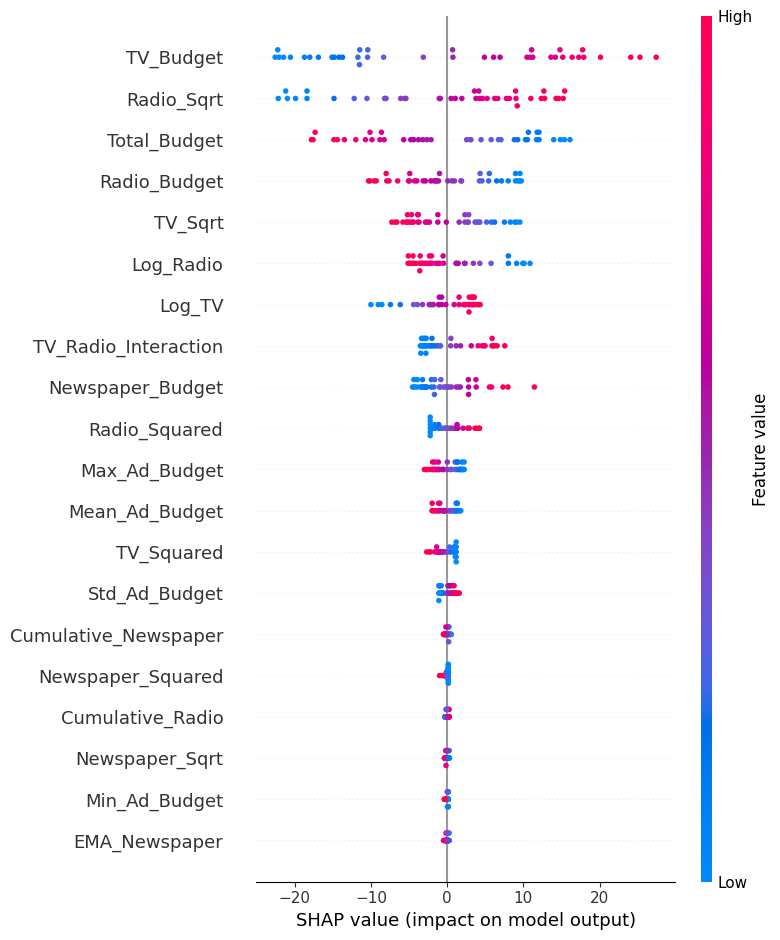

In [203]:
# Initialize SHAP JavaScript visualization
shap.initjs()

# Create SHAP explainer for the best model
explainer = shap.Explainer(best_model, X_test)
shap_values = explainer(X_test)

# Global SHAP Summary Plot
shap.summary_plot(shap_values, X_test)

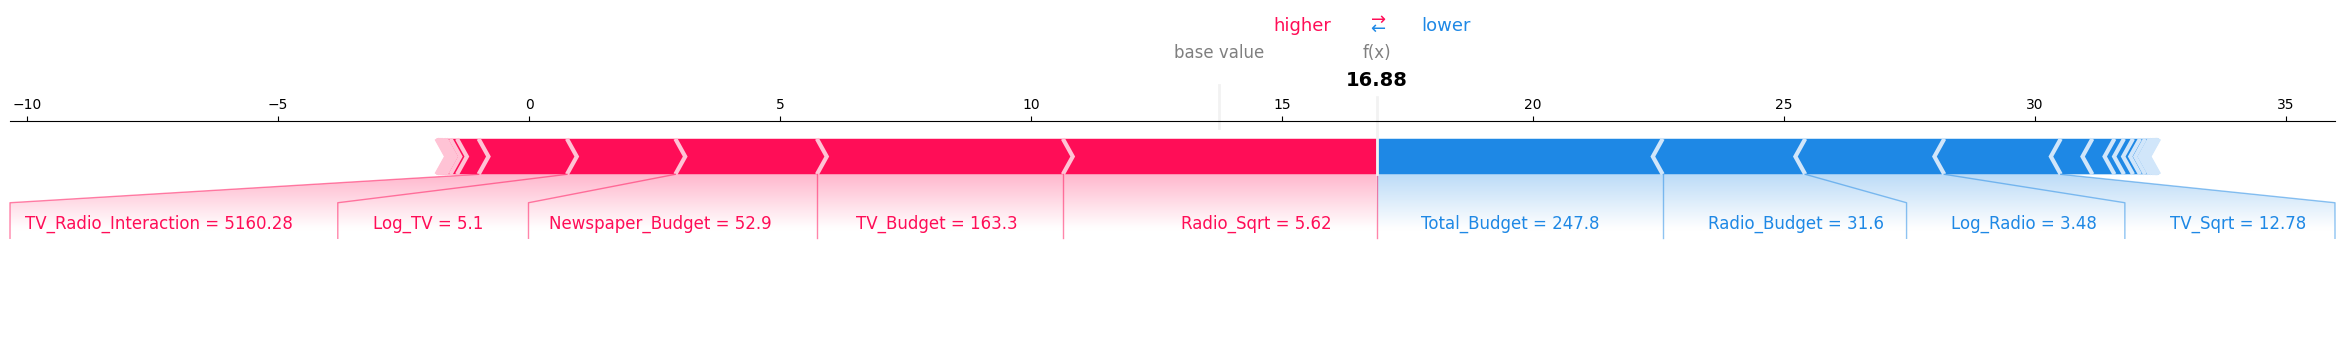

In [204]:
# Round SHAP values and feature values for better readability
rounded_shap_values = np.round(shap_values.values[0, :], 2)  # Round SHAP values to 2 decimal places
rounded_feature_values = np.round(X_test.iloc[0, :], 2)  # Round feature values to 2 decimal places

# Adjust the figure size for better readability
shap.force_plot(
    explainer.expected_value,
    rounded_shap_values,
    rounded_feature_values,
    matplotlib=True,
    figsize=(30, 3)
)

<h1>Trying Ensemble Techniques</h1>

In [205]:
collect_models

{'Linear Regression': LinearRegression(),
 'Random Forest': RandomForestRegressor(random_state=42),
 'Gradient Boosting': GradientBoostingRegressor(random_state=42),
 'XGBoost': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)}

In [206]:
ensemble = VotingRegressor(estimators=[
    (list(collect_models.keys())[0], list(collect_models.values())[0]),
    (list(collect_models.keys())[1], list(collect_models.values())[1]),
    (list(collect_models.keys())[2], list(collect_models.values())[2]),
    (list(collect_models.keys())[3], list(collect_models.values())[3]),
])

ensemble.fit(X_train, y_train)

VotingRegressor(estimators=[('Linear Regression', LinearRegression()),
                            ('Random Forest',
                             RandomForestRegressor(random_state=42)),
                            ('Gradient Boosting',
                             GradientBoostingRegressor(random_state=42)),
                            ('XGBoost',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_...
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...))])

In [207]:
# Make predictions and evaluate
y_pred = ensemble.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

In [208]:
print("Ensemble Model Performance:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

Ensemble Model Performance:
MAE: 0.44
RMSE: 0.54
R²: 0.99


In [209]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    mode='regression',
    discretize_continuous=True
)

# Pick an instance from the test set to explain
instance_idx = 0
instance = X_test.iloc[instance_idx].values

# Generate an explanation for the selected instance using our ensemble model
exp = explainer.explain_instance(
    instance,
    lambda x: ensemble.predict(pd.DataFrame(x, columns=X_train.columns)),
    num_features=10
)

# Display the explanation within the notebook
exp.show_in_notebook(show_table=True)

ImportError: cannot import name 'display' from 'IPython.core.display' (c:\Users\Singapore Athletic\Desktop\Alph\Sem2\BT5102\FinalProject\env\Lib\site-packages\IPython\core\display.py)

# Marketing Channel Optimization

In [ ]:
# Simulate budget adjustments with all features
def simulate_budget_adjustment(tv, radio, newspaper, data, X_train):
    # Create a new DataFrame for the input row
    new_data = pd.DataFrame({
        'TV_Budget': [tv],
        'Radio_Budget': [radio],
        'Newspaper_Budget': [newspaper]
    })

    # Recalculate all derived features based on the new budgets
    new_data['Total_Budget'] = new_data['TV_Budget'] + new_data['Radio_Budget'] + new_data['Newspaper_Budget']
    new_data['TV_Radio_Interaction'] = new_data['TV_Budget'] * new_data['Radio_Budget']
    new_data['TV_Newspaper_Interaction'] = new_data['TV_Budget'] * new_data['Newspaper_Budget']
    new_data['Radio_Newspaper_Interaction'] = new_data['Radio_Budget'] * new_data['Newspaper_Budget']
    new_data['TV_Radio_Ratio'] = new_data['TV_Budget'] / (new_data['Radio_Budget'] + 1e-5)
    new_data['TV_Newspaper_Ratio'] = new_data['TV_Budget'] / (new_data['Newspaper_Budget'] + 1e-5)
    new_data['Radio_Newspaper_Ratio'] = new_data['Radio_Budget'] / (new_data['Newspaper_Budget'] + 1e-5)
    new_data['Log_TV'] = np.log1p(new_data['TV_Budget'])
    new_data['Log_Radio'] = np.log1p(new_data['Radio_Budget'])
    new_data['Log_Newspaper'] = np.log1p(new_data['Newspaper_Budget'])
    new_data['TV_Squared'] = new_data['TV_Budget'] ** 2
    new_data['Radio_Squared'] = new_data['Radio_Budget'] ** 2
    new_data['Newspaper_Squared'] = new_data['Newspaper_Budget'] ** 2
    new_data['TV_Sqrt'] = np.sqrt(new_data['TV_Budget'])
    new_data['Radio_Sqrt'] = np.sqrt(new_data['Radio_Budget'])
    new_data['Newspaper_Sqrt'] = np.sqrt(new_data['Newspaper_Budget'])
    new_data['Mean_Ad_Budget'] = new_data[['TV_Budget', 'Radio_Budget', 'Newspaper_Budget']].mean(axis=1)
    new_data['Std_Ad_Budget'] = new_data[['TV_Budget', 'Radio_Budget', 'Newspaper_Budget']].std(axis=1)
    new_data['Max_Ad_Budget'] = new_data[['TV_Budget', 'Radio_Budget', 'Newspaper_Budget']].max(axis=1)
    new_data['Min_Ad_Budget'] = new_data[['TV_Budget', 'Radio_Budget', 'Newspaper_Budget']].min(axis=1)
    new_data['TV_Normalized'] = (new_data['TV_Budget'] - data['TV_Budget'].mean()) / data['TV_Budget'].std()
    new_data['Radio_Normalized'] = (new_data['Radio_Budget'] - data['Radio_Budget'].mean()) / data['Radio_Budget'].std()
    new_data['Newspaper_Normalized'] = (new_data['Newspaper_Budget'] - data['Newspaper_Budget'].mean()) / data['Newspaper_Budget'].std()
    new_data['Cumulative_TV'] = new_data['TV_Budget']  # For a single row, cumulative is the value itself
    new_data['Cumulative_Radio'] = new_data['Radio_Budget']
    new_data['Cumulative_Newspaper'] = new_data['Newspaper_Budget']
    new_data['Rolling_Mean_TV'] = new_data['TV_Budget']  # For a single row, rolling mean is the value itself
    new_data['Rolling_Mean_Radio'] = new_data['Radio_Budget']
    new_data['Rolling_Mean_Newspaper'] = new_data['Newspaper_Budget']
    new_data['EMA_TV'] = new_data['TV_Budget']  # For a single row, EMA is the value itself
    new_data['EMA_Radio'] = new_data['Radio_Budget']
    new_data['EMA_Newspaper'] = new_data['Newspaper_Budget']
    new_data['High_TV_Budget'] = (new_data['TV_Budget'] > data['TV_Budget'].mean()).astype(int)
    new_data['High_Radio_Budget'] = (new_data['Radio_Budget'] > data['Radio_Budget'].mean()).astype(int)
    new_data['High_Newspaper_Budget'] = (new_data['Newspaper_Budget'] > data['Newspaper_Budget'].mean()).astype(int)

    # Align new_data with the training data columns
    new_data = new_data[X_train.columns]

    # Predict sales using the best model
    predicted_sales = best_model.predict(new_data)
    return predicted_sales[0]

In [ ]:
# Example: Simulate a new budget allocation
tv_budget = 200
radio_budget = 50
newspaper_budget = 30
predicted_sales = simulate_budget_adjustment(tv_budget, radio_budget, newspaper_budget, df, X_train)
print(f"\nPredicted Sales for TV: ${tv_budget}, Radio: ${radio_budget}, Newspaper: ${newspaper_budget} -> ${predicted_sales:.2f}")


Predicted Sales for TV: $200, Radio: $50, Newspaper: $30 -> $23.62
